# Time Series Forecasting - Regression

### Terminology and Notations

__A time series__ is a series of measurements of a particular phenomena taken over time.

__Time series forecasting__ refers to generating a future value for the series of interests.

 
> $t$ = 1,2,3,...   time period index

> $Y_{t}$ = value of a series at time period $t$

> $F_{t+k}$ = forecast for time period $t+k$, using data until time $t$ 

> $e_{t+k} = Y_{t+k}-F_{t+k} $= forecast error (residual) for period $t+k$

__Level__ describes the average value of the series.

__Trend__ is the change in the series from one period to the next.

__Seasonality__ describes a short-term cyclical behavior of the series which can be observed several times within the given series.

__Noise__ is the random variation that results from measurement error or other causes not accounted for. It always present in a time series to some degree.

__Stationarity__  A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

Additive decomposition: $Y_{t} = L_{t}+T_{t} + S_{t}+ e_{t}$

Multiplicative decomposition: $Y_{t} = L_{t}* T_{t}*S_{t}*e_{t}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext version_information
%version_information pandas, matplotlib

Software versions
Python 3.7.5 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.18362 SP0
pandas 0.25.3
matplotlib 3.1.1
Fri Apr 03 13:32:16 2020 W. Europe Daylight Time

### >> Regression for Forecasting

* Get time series
* Partitioning into training/test
* Predictors in a model are temporal patterns
* Estimate the model in training
* Evaluate predictive performance on test period
* Generate forecast for future periods

> #### Model with Linear/Polynomial Trend

A time index $t = 1,2,3...$ is used as a single predictor in the regression model:

$$Y_{t} = \beta_{0}+\beta_{1}t+\beta_{2}t^{2}+...+\epsilon$$

where $\epsilon$ is a standard noise term in the regression model.  

In [3]:
amtrak = pd.read_csv('../data/Amtrak.csv')

In [4]:
amtrak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
Month        159 non-null object
Ridership    159 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [5]:
# covert date to datetime forma
amtrak['Date'] = pd.to_datetime(amtrak['Month'], format='%d/%m/%Y')

In [6]:
from statsmodels.tsa.tsatools import add_trend
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as sm

# add constant, linear trend t and polynomial trend t^2 to the data 
amtrak = add_trend(amtrak, trend='ctt')

C:\Users\Olena\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
amtrak.head()

,Month,Ridership,Date,const,trend,trend_squared
0,01/01/1991,1708.917,1991-01-01,1.0,1.0,1.0
1,01/02/1991,1620.586,1991-02-01,1.0,2.0,4.0
2,01/03/1991,1972.715,1991-03-01,1.0,3.0,9.0
3,01/04/1991,1811.665,1991-04-01,1.0,4.0,16.0
4,01/05/1991,1974.964,1991-05-01,1.0,5.0,25.0


In [8]:
# build a liner model for the trend
lm = sm.ols('Ridership ~ trend', data=amtrak).fit()

In [9]:
# build a polynomial model for the trend
polym = sm.ols('Ridership ~ trend+trend_squared', data=amtrak).fit()

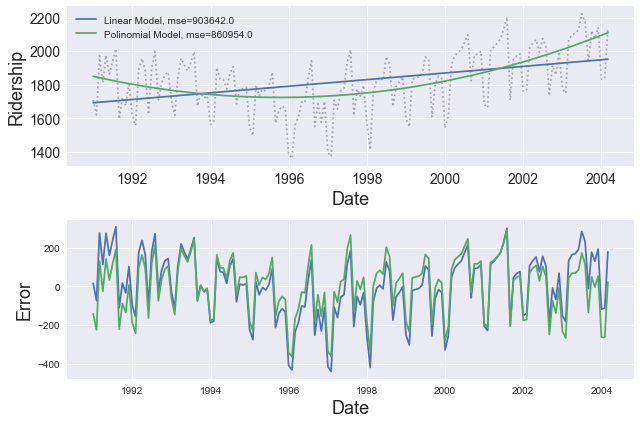

In [10]:
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,6))

ax[0].plot(amtrak.set_index('Date').Ridership, color='k',
        linestyle=':', alpha=0.3)

ax[0].plot(amtrak.Date, lm.fittedvalues, label=f'Linear Model, mse={round(lm.mse_model)}')
ax[0].plot(amtrak.Date, polym.fittedvalues, label=f'Polinomial Model, mse={round(polym.mse_model)}')

ax[0].set_xlabel('Date', fontsize=18)
ax[0].set_ylabel('Ridership', fontsize=18)

ax[0].tick_params(labelsize=14)

ax[0].legend()

ax[1].plot(amtrak['Date'], amtrak.Ridership - lm.fittedvalues, label= 'lm')
ax[1].plot(amtrak['Date'], amtrak.Ridership - polym.fittedvalues, label= 'poly')

ax[1].set_xlabel('Date', fontsize=18)
ax[1].set_ylabel('Error', fontsize=18)

ax[0].tick_params(labelsize=14)


plt.tight_layout()
plt.show()
plt.close()

> #### Model with Seasonality

Seasonality is captured in a regression model by creating a new categorical variable that denotes the season for each value. 

In [11]:
# add new variable that indicates season
amtrak['Season'] = amtrak['Date'].dt.month

In [12]:
poly_season = sm.ols('Ridership ~ trend+trend_squared+C(Season)', data=amtrak).fit() 

In [13]:
# adding seasonal variable to the models leads to multicollinearity between independent variables
poly_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     64.82
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           1.24e-53
Time:                        13:32:18   Log-Likelihood:                -899.70
No. Observations:                 159   AIC:                             1827.
Df Residuals:                     145   BIC:                             1870.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1656.3618     25.109     65.968      0.000    1606.736    1705.988
C(Season)[T.2]    -36.1436     27.458     -1.316      0.190     -90.414      18.127
C(Season)[T.3]    262.2533     27.459      9.551      0.000     207.981     316.525
C(Season)[T.4]    271.5141     28.000      9.697      0.000     216.174     326.854
C(Season)[T.5]    299.4401     27.999     10.695      0.000     244.101     354.779
C(Season)[T.6]    261.7180     27.999      9.348      0.000     206.380     317.056
C(Season)[T.7]    363.8054     27.999     12.994      0.000     308.467     419.144
C(Season)[T.8]    399.9966     27.999     14.286      0.000     344.658     455.336
C(Season)[T.9]     72.1940     28.000      2.578      0.011      16.853     127.534
C(Season)[T.10]   213.8048     28.001      7.636      0.000     158.462     269.147
C(Season)[T.11]   199.3614     28.002      7.119      0.000     144.016     254.707
C(Season)[T.12]   243.1286     28.004      8.682      0.000     187.780     298.478
trend              -4.9402      0.506     -9.755      0.000      -5.941      -3.939
trend_squared       0.0413      0.003     13.458      0.000       0.035       0.047
==============================================================================
Omnibus:                        8.117   Durbin-Watson:                   0.719
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                7.942
Skew:                          -0.531   Prob(JB):                       0.0189
Kurtosis:                       3.266   Cond. No.                     1.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

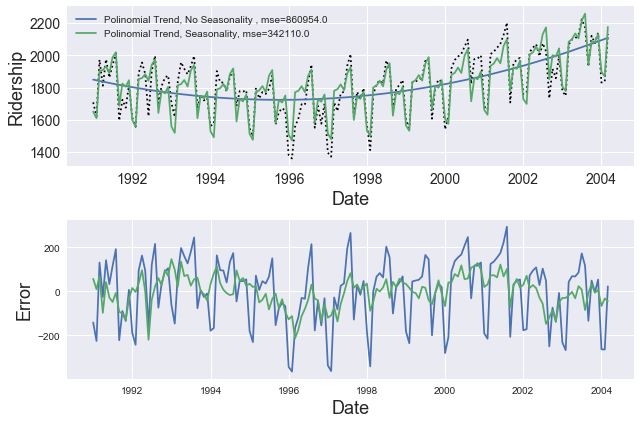

In [14]:
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,6))

ax[0].plot(amtrak.set_index('Date').Ridership, color='k',linestyle=':')

ax[0].plot(amtrak.Date, polym.fittedvalues, label=f'Polinomial Trend, No Seasonality , mse={round(polym.mse_model)}')
ax[0].plot(amtrak.Date, poly_season.fittedvalues, label=f'Polinomial Trend, Seasonality, mse={round(poly_season.mse_model)}')

ax[0].set_xlabel('Date', fontsize=18)
ax[0].set_ylabel('Ridership', fontsize=18)

ax[0].tick_params(labelsize=14)
ax[0].legend()

ax[1].plot(amtrak['Date'], amtrak.Ridership - polym.fittedvalues, label= 'poly')
ax[1].plot(amtrak['Date'], amtrak.Ridership - poly_season.fittedvalues, label= 'poly+seasonality')

ax[1].set_xlabel('Date', fontsize=18)
ax[1].set_ylabel('Error', fontsize=18)

ax[0].tick_params(labelsize=14)


plt.tight_layout()
plt.show()
plt.close()

Correlation between values of a time series in neighboring periods is called autocorrelation,
because it describes a relationship between the series and itself. To compute autocorrelation, we compute the correlation between the series and a lagged version of the series. A lagged series is a 'copy' of the original series which is moved forward one or more time periods.

> #### Autoregressive Model

An autoregressive model is when a value from a time series is regressed on previous values from that same time series.

$$Y_{t}= \beta_{0}+\beta_{1}Y_{t-1}+...+\beta_{t-k}Y_{t-k}+\epsilon_{t}$$

This is a model is $k-order$ autoregression model $AR(k)$. (Applied for stationary time series.) 

Autocorrelation = compute correlation between original series $Y_{t}$ and lagged series $Y_{t-k}$ for lags $k=1,2,3...$

In [15]:
# Lag Time Data By i Row
# Lag_i: Lag_i[i]=y[i-1]

lags = pd.DataFrame()
for i in range(0,12):
    lags.loc[:, f'Lag{i}'] = amtrak.Ridership.shift(i)

In [16]:
lags

,Lag0,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11
0,1708.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1620.586,1708.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1972.715,1620.586,1708.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1811.665,1972.715,1620.586,1708.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1974.964,1811.665,1972.715,1620.586,1708.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
154,2076.054,2121.470,1931.406,2174.360,2223.349,2129.671,2104.911,2098.899,2066.466,1749.489,1778.033,1996.352
155,2140.677,2076.054,2121.470,1931.406,2174.360,2223.349,2129.671,2104.911,2098.899,2066.466,1749.489,1778.033
156,1831.508,2140.677,2076.054,2121.470,1931.406,2174.360,2223.349,2129.671,2104.911,2098.899,2066.466,1749.489
157,1838.006,1831.508,2140.677,2076.054,2121.470,1931.406,2174.360,2223.349,2129.671,2104.911,2098.899,2066.466


In [17]:
lags.corr()

,Lag0,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11
Lag0,1.000000,0.565867,0.360738,0.365938,0.415302,0.254166,-0.085151,0.235382,0.376978,0.294856,0.261019,0.476264
Lag1,0.565867,1.000000,0.570122,0.363439,0.353356,0.405994,0.239765,-0.093520,0.217654,0.360477,0.279680,0.246078
Lag2,0.360738,0.570122,1.000000,0.570107,0.366170,0.354881,0.408873,0.239691,-0.096160,0.220093,0.363311,0.281360
Lag3,0.365938,0.363439,0.570107,1.000000,0.575287,0.368159,0.357654,0.409214,0.242163,-0.098966,0.221811,0.366169
Lag4,0.415302,0.353356,0.366170,0.575287,1.000000,0.568397,0.355558,0.354165,0.395091,0.221090,-0.123416,0.205487
Lag5,0.254166,0.405994,0.354881,0.368159,0.568397,1.000000,0.561568,0.352254,0.342004,0.382518,0.207197,-0.142489
Lag6,-0.085151,0.239765,0.408873,0.357654,0.355558,0.561568,1.000000,0.560347,0.337386,0.324655,0.369350,0.191178
Lag7,0.235382,-0.093520,0.239691,0.409214,0.354165,0.352254,0.560347,1.000000,0.560026,0.333917,0.320731,0.366003
Lag8,0.376978,0.217654,-0.096160,0.242163,0.395091,0.342004,0.337386,0.560026,1.000000,0.545983,0.316934,0.304431
Lag9,0.294856,0.360477,0.220093,-0.098966,0.221090,0.382518,0.324655,0.333917,0.545983,1.000000,0.532934,0.298242


Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. 

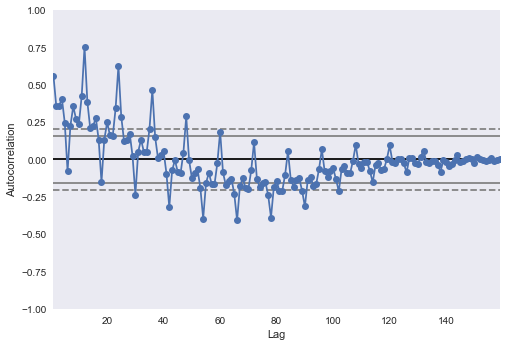

In [18]:
pd.plotting.autocorrelation_plot(amtrak.Ridership,marker='o')
plt.show()

In [19]:
# autocorrelation function ACF
# amtrak.set_index('Date')['Ridership'].autocorr(lag=3)

__ARIMA__ (Autoregressive Integrated Moving Average) models

* Capture autocorrelation in the series by modeling it directly
* Use for forecasting
* Strong underlying theory, flexible
* Danger of over-fitting
* Hard to explain model and to interpret coefficients 

To choose ARIMA parameters we need to perform visual inspection

* seasonality and trends

* autocorrelation chart

* partial autocorrelation chart

ARIMA(p,d,q, P,D,Q)

d = order of Lag-1 differencing (How many time to perform lag-1 differencing $y_{t}-y_{t-1}$), used for removing trend

D = order of Seasonal differencing (Seasonal lag-M differencing $y_{t}-y_{t-M}$ ), used for removing seasonality



> * Use differencing to remove trend and seasonality

> * Keep it simple ($d,D=\{0,1\}$, small $p,q$, $P,Q=\{0,1\}$)

> * Beware of over-differencing 

More details: [Statistical forecasting:
notes on regression and time series analysis](https://people.duke.edu/~rnau/411home.htm)